## Clinical Data Preprocessing

Load → Split → Impute/Scale (KNN + QuantileTransformer) → Save

In [9]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import ClinicalDataLoader
from src.features import ClinicalPreprocessor
from src.visualization import plot_before_after_histogram

In [10]:
DATA_PATH = Path("../data/raw/dataset.xlsx")
OUT_PATH = Path("../data/processed/01_cleaned_advanced.csv")
FIG_DIR = Path("../figures")
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

loader = ClinicalDataLoader(DATA_PATH)
features, meta = loader.load_cohort(min_labs=10, max_missing=0.9)
df = pd.concat([meta, features], axis=1)

print(f"Loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Loaded: 603 rows, 51 columns


In [11]:
preprocessor = ClinicalPreprocessor(n_neighbors=5, output_distribution="normal")
X_clean, X_pca = preprocessor.fit_transform(features)

output = meta.copy()
for c in X_clean.columns:
    output[c] = X_clean[c].values
output.to_csv(OUT_PATH, index=False)
print(f"Saved: {OUT_PATH}")

Saved: ..\data\processed\01_cleaned_advanced.csv


c:\Users\amitf\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (603). n_quantiles is set to n_samples.
  warnings.warn(


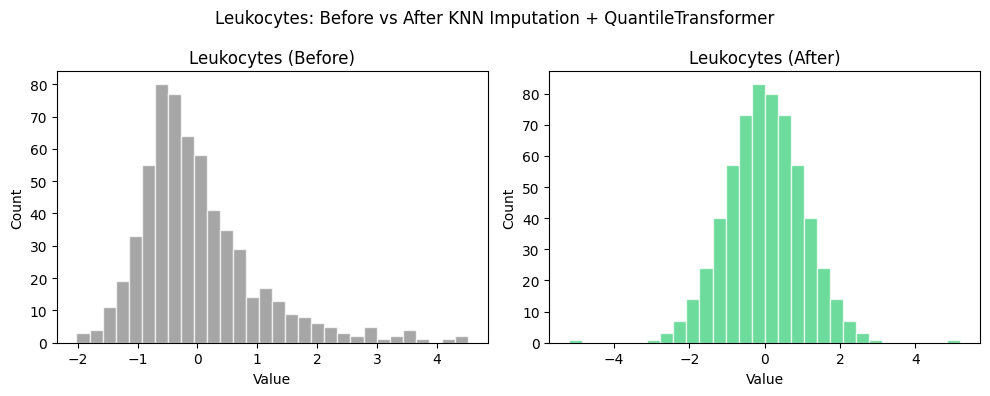

In [12]:
feat_name = "Leukocytes"
if feat_name in features.columns and feat_name in X_clean.columns:
    plot_before_after_histogram(
        features[feat_name],
        X_clean[feat_name],
        feature_name=feat_name,
        title="Leukocytes: Before vs After KNN Imputation + QuantileTransformer",
        save_path=str(FIG_DIR / "leukocytes_before_after.png"),
    )
else:
    print(f"'{feat_name}' not found. Available: {list(features.columns[:5])}...")

**Explanation – Before vs After (Leukocytes)**  
This figure compares the distribution of leukocyte counts (Leukocytes) before and after the preprocessing step.  
- The left panel shows the raw data – typically skewed, with heavy tails and extreme outliers.  
- The right panel shows the same patients after KNN imputation and QuantileTransformer normalization.  
It provides a focused example of how the cleaning and scaling pipeline reshapes a single clinically important feature before we zoom out to grid plots and heatmaps.

## Data Quality & Transformation Audit

Visualizing the data quality journey: sparsity, transformation effect, and preserved correlations.

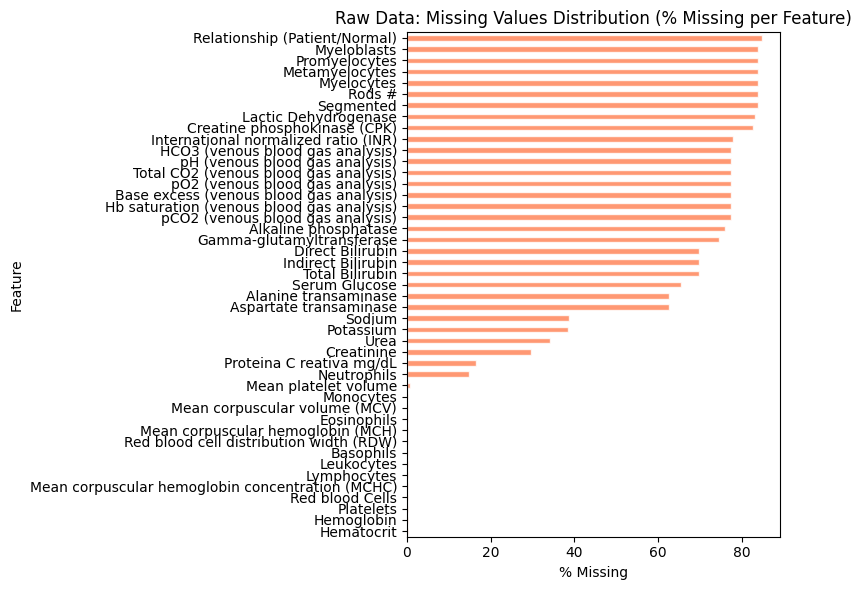

In [13]:
# 1. Missing Values Map
missing_pct = features.isna().mean() * 100
missing_pct = missing_pct.sort_values(ascending=True)
plt.figure(figsize=(8, 6))
missing_pct.plot(kind="barh", color="coral", alpha=0.8, edgecolor="white")
plt.title("Raw Data: Missing Values Distribution (% Missing per Feature)")
plt.xlabel("% Missing")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(FIG_DIR / "missing_values_map.png", dpi=300)
plt.show()

**Explanation – Missing Values Map**  
This chart shows, for each feature, the percentage of missing values (Missing %).  
It allows us to quickly see which lab tests are well measured (very few missing values) and which are almost never measured (very high missingness).  
This information explains why we drop features above a certain threshold (for example >90% missing), and why we need imputation at all – there are many holes in the raw data matrix.

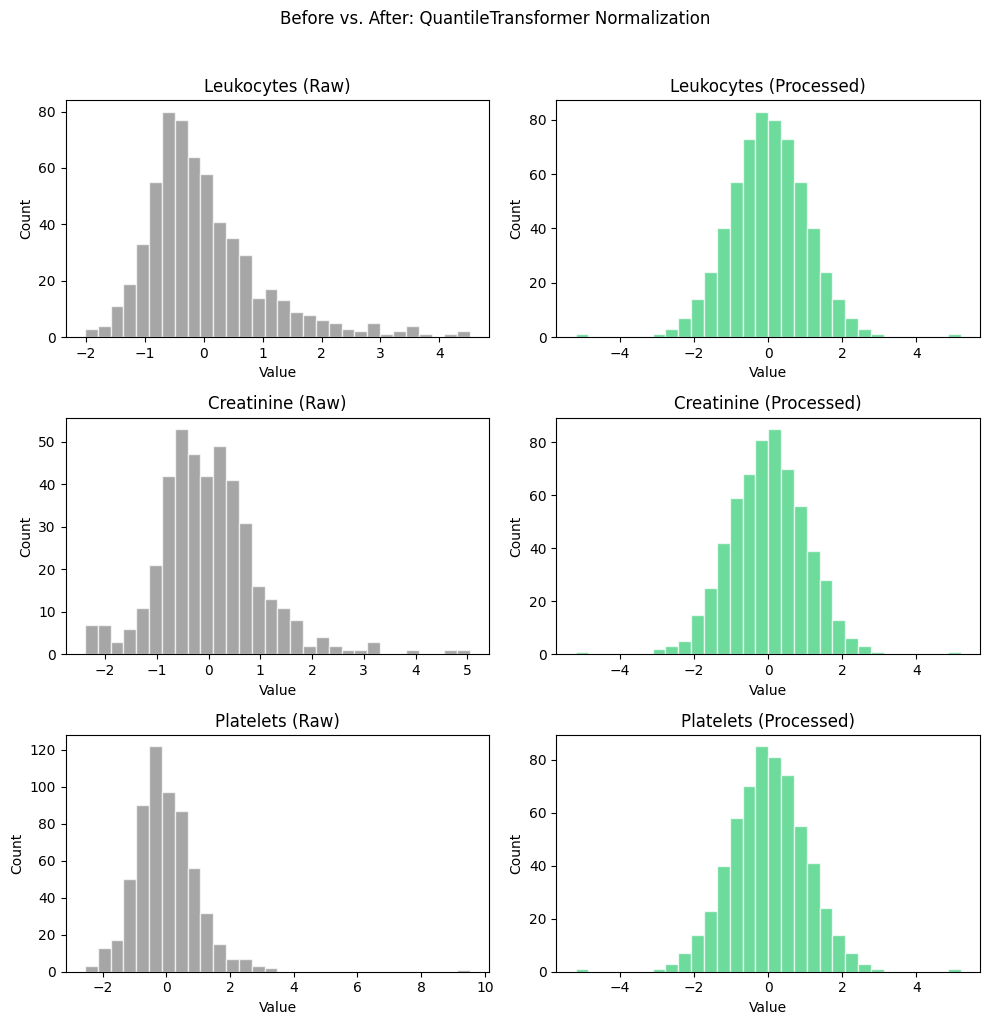

In [14]:
# 2. Before vs. After Distribution Grid (QuantileTransformer effect)
biomarkers = ["Leukocytes", "Creatinine", "Platelets"]
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, feat in enumerate(biomarkers):
    if feat not in features.columns or feat not in X_clean.columns:
        continue
    axes[i, 0].hist(features[feat].dropna(), bins=30, color="gray", alpha=0.7, edgecolor="white")
    axes[i, 0].set_title(f"{feat} (Raw)")
    axes[i, 0].set_xlabel("Value")
    axes[i, 0].set_ylabel("Count")
    axes[i, 1].hist(X_clean[feat].dropna(), bins=30, color="#2ecc71", alpha=0.7, edgecolor="white")
    axes[i, 1].set_title(f"{feat} (Processed)")
    axes[i, 1].set_xlabel("Value")
    axes[i, 1].set_ylabel("Count")
plt.suptitle("Before vs. After: QuantileTransformer Normalization", fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / "before_after_grid.png", dpi=300)
plt.show()

**Explanation – Before vs. After Distribution Grid**  
In this grid we examine three key clinical biomarkers (Leukocytes, Creatinine, Platelets) before and after preprocessing.  
- The left column shows the raw distribution – typically skewed, with long tails and many outliers.  
- The right column shows the same test after KNN Imputer + QuantileTransformer – a distribution that is closer to Gaussian, centered, and less dominated by extreme values.  
The goal is to visually demonstrate how the transformation turns "statistically hard" data into data that is more suitable for linear models, PCA, and clustering algorithms.

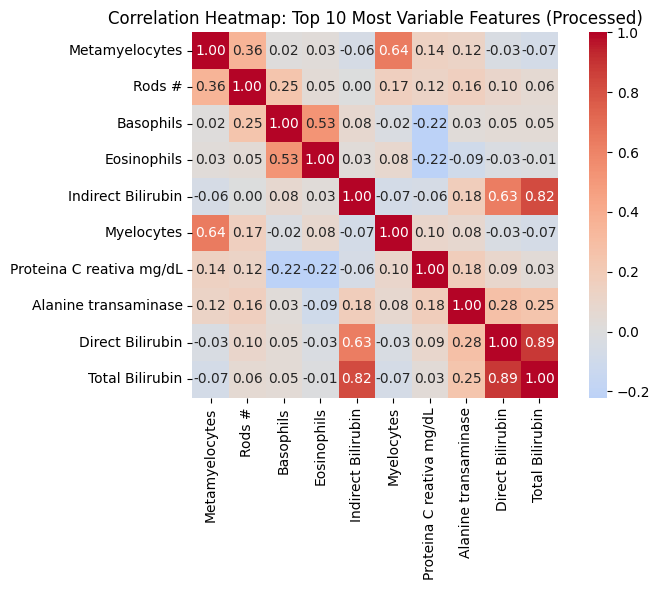

In [15]:
# 3. Correlation Check - Top 10 most variable features (Processed)
top_var = X_clean.var().nlargest(10).index.tolist()
corr = X_clean[top_var].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, fmt=".2f", square=True)
plt.title("Correlation Heatmap: Top 10 Most Variable Features (Processed)")
plt.tight_layout()
plt.savefig(FIG_DIR / "correlation_heatmap.png", dpi=300)
plt.show()

**Explanation – Correlation Heatmap (Processed Top 10 Features)**  
The heatmap shows the Pearson correlation coefficients between the 10 most variable features after all preprocessing steps (KNN Imputer + QuantileTransformer).  
Its purpose is to demonstrate that the underlying biological relationships between blood tests are preserved after preprocessing:  
- Positive correlations (red) indicate tests that tend to increase or decrease together.  
- Negative correlations (blue) indicate tests that behave in opposite directions.  
This helps us verify that the transformation did not "flatten" the data and that a rich clinical structure between features is still present before we move to PCA and clustering in Notebook 02.

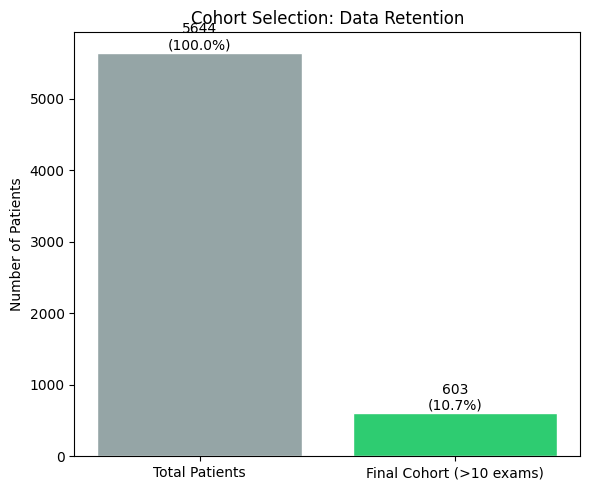

In [16]:
# 4. Cohort Selection: Data Retention
raw_df = pd.read_excel(DATA_PATH)
n_raw = len(raw_df)
n_final = len(df)
labels = ["Total Patients", "Final Cohort (>10 exams)"]
values = [n_raw, n_final]
colors = ["#95a5a6", "#2ecc71"]
pcts = [100.0, 100.0 * n_final / n_raw if n_raw > 0 else 0]

fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(labels, values, color=colors, edgecolor="white")
ax.set_title("Cohort Selection: Data Retention")
ax.set_ylabel("Number of Patients")
for bar, val, pct in zip(bars, values, pcts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f"{val}\n({pct:.1f}%)", ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.savefig(FIG_DIR / "cohort_selection_funnel.png", dpi=300)
plt.show()

**Explanation – Cohort Selection: Data Retention**  
This chart shows how many patients we had in the original raw file (Total Patients) and how many remain after the final cohort selection (Final Cohort, only patients with ≥10 lab tests).  
The goal is to show how much data was removed for quality reasons (few tests → less reliable information), and what percentage of the original sample actually participates in the downstream clinical and statistical analyses.